In [1]:
import copy
import numpy as np
import pfea.solver as ksolver

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import cKDTree 
import networkx as nx
import itertools

np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

import sympy
from sympy.matrices import Matrix

In [2]:
#Basic node-bar definitions for an octahedron

nodes = np.array([[0.0,0.5,0.5],
                  [0.5,0.0,0.5],
                  [0.5,0.5,0.0],
                  [0.5,0.5,1.0],
                  [0.5,1.0,0.5],
                  [1.0,0.5,0.5]])

bars = np.array([[0,1],
                 [0,2],
                 [0,3],
                 [0,4],
                 [1,2],
                 [1,3],
                 [1,5],
                 [2,4],
                 [2,5],
                 [3,4],
                 [3,5],
                 [4,5]])

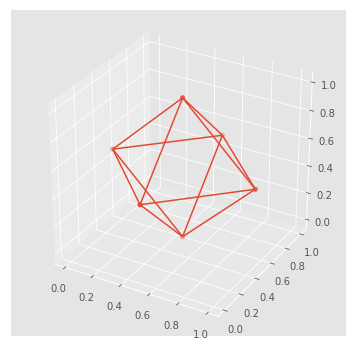

In [3]:
#Testing 1x1x1 plot

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in bars:
    line_segments.append([nodes[bar[0]],nodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)
    
ax.scatter(nodes.T[0],nodes.T[1],nodes.T[2])
ax.add_collection(line_segments)
plt.show()

In [4]:
def gen_B_matrices_from_nodes(nodes):
    maxval = np.max(aux_nodes.T[0])
    minval = np.min(aux_nodes.T[0])

    b_0 = []
    b_a = []
    n = 0
    for node in nodes:
        if (np.abs(node - maxval) < 0.0001).any():
            per_coord = np.array([int(a) for a in np.abs(node - maxval) < 0.01])
            b_a_row = []
            for i,per_coord_val in enumerate(per_coord):
                if per_coord_val == 1:
                    b_a_row.append(i)
            b_a.append(b_a_row)
            newnode = node-per_coord*(maxval-minval)
            for i,diff in enumerate(aux_nodes-newnode):
                if (np.abs(diff) < 0.0001).all():
                    b_0.append(b_0[i])
        else:
            b_0.append(n)
            b_a.append([])
            n = n+1 
    
    B_0 = np.zeros((len(b_0)*6,(max(b_0)+1)*6))
    B_a = np.zeros((len(b_0)*6,9))
    
    for row,col in enumerate(b_0):
        for i in range(6):
            B_0[row*6+i][col*6+i] = 1.0

    for row,cols in enumerate(b_a):
        for col in cols:
            for i in range(3):
                B_a[row*6+i][col*3+i] = 1.0
    
    return B_0, B_a

In [13]:
#Methods for transforming the octahedron.

#mirror planes, defined by norm (needs to be of length 1) and offset (can be anything)
def mir(tnodes, tbars, norm=(0,0,1),offset=(0,0,0)):
    norm = np.array(norm)/np.linalg.norm(np.array(norm))
    offset = np.dot(norm,np.array(offset))
    reflected_nodes = np.copy(tnodes)
    reflected_nodes = reflected_nodes-offset
    reflected_nodes = reflected_nodes.T
    for i in range(len(norm)):
        if norm[i] != 0:
            reflected_nodes[i] = reflected_nodes[i]*(-norm[i])
    
    reflected_nodes = reflected_nodes.T+offset
    
    return (np.vstack((tnodes,reflected_nodes)), np.vstack((tbars,tbars+np.shape(reflected_nodes)[0])))

def rotate_about_axis(nodes, axis, angle):
    axis = np.array(axis)
    axis = axis/np.linalg.norm(axis)
    a = np.cos(angle/2)
    b = axis[0]*np.sin(angle/2)
    c = axis[1]*np.sin(angle/2)
    d = axis[2]*np.sin(angle/2)
    e_r = np.array([[a**2+b**2-c**2-d**2,         2*(b*c-a*d),         2*(b*d+a*c)],
                    [        2*(b*c+a*d), a**2+c**2-b**2-d**2,         2*(c*d-a*b)],
                    [        2*(b*d-a*c),         2*(c*d+a*b), a**2+d**2-b**2-c**2]])
    return np.array([np.dot(e_r,node) for node in nodes])

def unique_points(a,tol=1e-5,leafsize=10):
    #Use KDTree to do uniqueness check within tolerance.
    pairs = cKDTree(a,leafsize=leafsize).query_pairs(tol)  #pairs of (i,j) where i<j and d(a[i]-a[j])<tol
    components = pairs# map(sorted, nx.connected_components(nx.Graph(data=list(pairs)))) #sorted connected components of the proximity graph
    idx = np.delete( np.arange(np.shape(a)[0]),  list(itertools.chain(*[c[1:] for c in components])) ) #all indices of a, except nodes past first in each component
    inv = np.arange(np.shape(a)[0])
    for c in components: inv[c[1:]]=c[0]
    inv = np.searchsorted(idx,inv)
    return idx,inv

def unique_reduce(tnodes,tbars):
    #reduced_idx,reduced_inv = unique_rows(nodes)
    reduced_idx,reduced_inv = unique_points(tnodes)
    return tnodes[reduced_idx],reduced_inv[tbars]

def CO_base_nodes(theta):
    base_nodes = np.array([[0.0,0.5,0.5],
                           [0.5,0.0,0.5],
                           [0.5,0.5,0.0],
                           [0.5,0.5,1.0],
                           [0.5,1.0,0.5],
                           [1.0,0.5,0.5]])
    base_nodes = rotate_about_axis(base_nodes,[1,1,1],theta)
    return base_nodes

def CO_A2g(theta):
    base_nodes = CO_base_nodes(theta)
    ret_nodes,ret_bars = mir(base_nodes, bars,norm=(0,0,1),offset=(0,0,base_nodes[3][2]))
    ret_nodes,ret_bars = mir(ret_nodes, ret_bars,norm=(0,1,0),offset=(0,base_nodes[4][1],0))
    ret_nodes,ret_bars = mir(ret_nodes, ret_bars,norm=(1,0,0),offset=(base_nodes[5][0],0,0))
    ret_nodes, ret_bars = unique_reduce(ret_nodes,ret_bars)
    
    rot_nodes, rot_bars = gen_auxetic_cuboct_unsorted(theta)
    
    rot_ind = np.lexsort((rot_nodes.T[2],rot_nodes.T[1],rot_nodes.T[0]))
    ind_of_rot_ind = np.argsort(rot_ind)
    
    new_rot_bars = []
    for bar in rot_bars:
        new_rot_bars.append([ind_of_rot_ind[bar[0]],ind_of_rot_ind[bar[1]]])
    
    new_rot_bars = np.array(new_rot_bars)
    bar_ind = np.lexsort((new_rot_bars.T[1],new_rot_bars.T[0]))
    
    return 0.5*rot_nodes[rot_ind],new_rot_bars[bar_ind]


def CO_A2g_LSM(theta):
    aux_nodes, aux_bars = CO_A2g(theta)

    B_0, B_a = gen_B_matrices_from_nodes(aux_nodes)
    
    return aux_nodes, aux_bars, B_0, B_a
    
def CO_theta_from_strain(strain):
    return 2*np.arcsin(np.sqrt(0.75*(1-strain)))

In [14]:
CO_A2g_LSM(0.1)

NameError: name 'gen_auxetic_cuboct_unsorted' is not defined

In [12]:
t,e = sympy.symbols('t e')
axis = np.array([1,1,1])
axis = axis/np.linalg.norm(axis)

nodes = CO_base_nodes(0)

a = sympy.cos(t/2)
b = axis[0]*sympy.sin(t/2)
c = axis[1]*sympy.sin(t/2)
d = axis[2]*sympy.sin(t/2)
e_r = Matrix([[a**2+b**2-c**2-d**2,         2*(b*c-a*d),         2*(b*d+a*c)],
                [        2*(b*c+a*d), a**2+c**2-b**2-d**2,         2*(c*d-a*b)],
                [        2*(b*d-a*c),         2*(c*d+a*b), a**2+d**2-b**2-c**2]])

dist = (Matrix(e_r.dot(nodes[-1]))-Matrix(e_r.dot(nodes[0])))[0]

dist


-0.333333333333333*sin(t/2)**2 + 1.0*cos(t/2)**2

$$
-\frac{4}{3}\textrm{sin}^2(\frac{t}{2})+1 = \epsilon
$$

$$
t = 2\textrm{sin}^{-1}\sqrt{\frac{3}{4}\left(1-\epsilon\right)}
$$

$$
t = 2\textrm{sin}^{-1}\left(\sqrt{\frac{3}{4}\left(1-\frac{1}{\epsilon+1}\right)}\right)
$$

$$
t = 2\textrm{sin}^{-1}\left(\sqrt{\frac{3}{4}\left(\frac{\epsilon}{\epsilon+1}\right)}\right)
$$

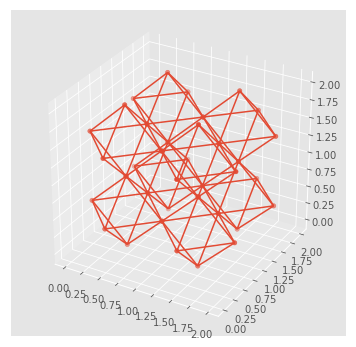

In [4]:
tnodes, tbars = mir(nodes,bars,offset=(0,0,1))
tnodes,tbars = mir(tnodes,tbars,norm=(0,1,0),offset=(0,1,0))
tnodes,tbars = mir(tnodes,tbars,norm=(1,0,0),offset=(1,0,0))

fig = plt.figure(figsize=(6,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in tbars:
    line_segments.append([tnodes[bar[0]],tnodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)
    
ax.scatter(tnodes.T[0],tnodes.T[1],tnodes.T[2])
ax.add_collection(line_segments)
plt.show()

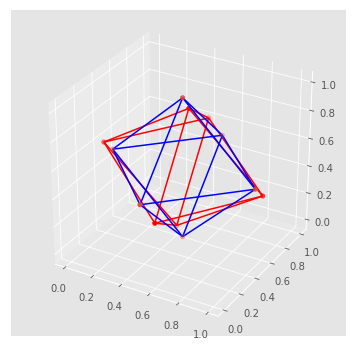

In [5]:
tnodes = gen_base_nodes(0.1)

#Testing 1x1x1 rotation

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')


line_segments = []
for bar in bars:
    line_segments.append([nodes[bar[0]],nodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments,colors='b')
ax.add_collection(line_segments)

line_segments = []
for bar in bars:
    line_segments.append([tnodes[bar[0]],tnodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments,colors='r')
ax.add_collection(line_segments)
    
ax.scatter(nodes.T[0],nodes.T[1],nodes.T[2])
ax.scatter(tnodes.T[0],tnodes.T[1],tnodes.T[2],c='r')
plt.show()

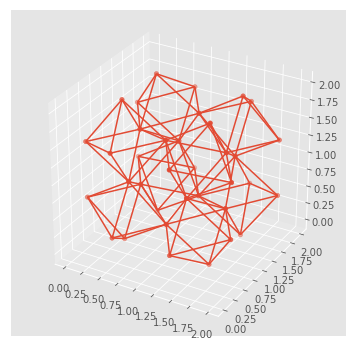

In [8]:
tnodes = gen_base_nodes(0.1)
tnodes, tbars = mir(tnodes,  bars,(1,0,0),tnodes[5])
tnodes, tbars = mir(tnodes, tbars,(0,1,0),tnodes[4])
tnodes, tbars = mir(tnodes, tbars,(0,0,1),tnodes[3])

fig = plt.figure(figsize=(6,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in tbars:
    line_segments.append([tnodes[bar[0]],tnodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)
    
ax.scatter(tnodes.T[0],tnodes.T[1],tnodes.T[2])
ax.add_collection(line_segments)
plt.show()

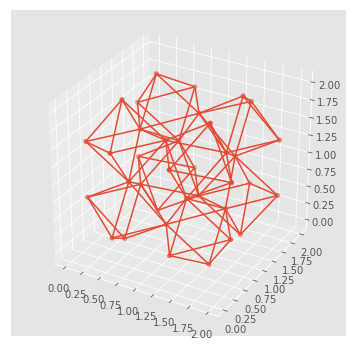

In [9]:
#Testing Point/Bar Cull

tnodes = gen_base_nodes(0.1)
tnodes, tbars = mir(tnodes,  bars,(1,0,0),tnodes[5])
tnodes, tbars = mir(tnodes, tbars,(0,1,0),tnodes[4])
tnodes, tbars = mir(tnodes, tbars,(0,0,1),tnodes[3])

unique_points(tnodes)
tnodes, tbars = unique_reduce(tnodes,tbars)

fig = plt.figure(figsize=(6,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in tbars:
    line_segments.append([tnodes[bar[0]],tnodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)
    
ax.scatter(tnodes.T[0],tnodes.T[1],tnodes.T[2])
ax.add_collection(line_segments)
plt.show()

In [10]:
Be = np.zeros((9,6))
Be[0][0] = 1.0
Be[4][1] = 1.0
Be[8][2] = 1.0
Be[1][3] = 0.5
Be[2][5] = 0.5
Be[3][3] = 0.5
Be[5][4] = 0.5
Be[6][5] = 0.5
Be[7][4] = 0.5

B_0_coords = [ 0, 1, 2, 3,
               4, 5, 6, 7, 6, 8, 9,10,11,10, 4, 5,
              12,13,14,15,
              16,17,18,19,18,20,21,22,23,22,16,17,
               0, 1, 2, 3]
B_a_coords = [[],[],[],[],
              [],[],[],[],[2],[],[],[],[],[2],[1],[1],
              [],[],[],[],
              [],[],[],[],[2],[],[],[],[],[2],[1],[1],
              [0],[0],[0],[0]]


B_0 = np.zeros((len(B_0_coords)*6,(max(B_0_coords)+1)*6))

for row,col in enumerate(B_0_coords):
    for i in range(6):
        B_0[row*6+i][col*6+i] = 1.0

B_a = np.zeros((len(B_0_coords)*6,9))

for row,cols in enumerate(B_a_coords):
    for col in cols:
        for i in range(3):
            B_a[row*6+i][col*3+i] = 1.0

[[ 0.    0.24  0.26]
 [ 0.    0.24  0.74]
 [ 0.    0.76  0.26]
 [ 0.    0.76  0.74]
 [ 0.26  0.    0.24]
 [ 0.26  0.    0.76]
 [ 0.24  0.26  0.  ]
 [ 0.26  0.24  0.5 ]
 [ 0.24  0.26  1.  ]
 [ 0.24  0.5   0.26]
 [ 0.24  0.5   0.74]
 [ 0.24  0.74  0.  ]
 [ 0.26  0.76  0.5 ]
 [ 0.24  0.74  1.  ]
 [ 0.26  1.    0.24]
 [ 0.26  1.    0.76]
 [ 0.5   0.26  0.24]
 [ 0.5   0.26  0.76]
 [ 0.5   0.74  0.24]
 [ 0.5   0.74  0.76]
 [ 0.74  0.    0.24]
 [ 0.74  0.    0.76]
 [ 0.76  0.26  0.  ]
 [ 0.74  0.24  0.5 ]
 [ 0.76  0.26  1.  ]
 [ 0.76  0.5   0.26]
 [ 0.76  0.5   0.74]
 [ 0.76  0.74  0.  ]
 [ 0.74  0.76  0.5 ]
 [ 0.76  0.74  1.  ]
 [ 0.74  1.    0.24]
 [ 0.74  1.    0.76]
 [ 1.    0.24  0.26]
 [ 1.    0.24  0.74]
 [ 1.    0.76  0.26]
 [ 1.    0.76  0.74]]
[[ 0  4]
 [ 0  6]
 [ 0  7]
 [ 0  9]
 [ 1  5]
 [ 1  7]
 [ 1  8]
 [ 1 10]
 [ 2  9]
 [ 2 11]
 [ 2 12]
 [ 2 14]
 [ 3 10]
 [ 3 12]
 [ 3 13]
 [ 3 15]
 [ 4  6]
 [ 4  7]
 [ 4 16]
 [ 5  7]
 [ 5  8]
 [ 5 17]
 [ 6  9]
 [ 6 16]
 [ 7  9]
 [ 7 10]
 [ 7 16]


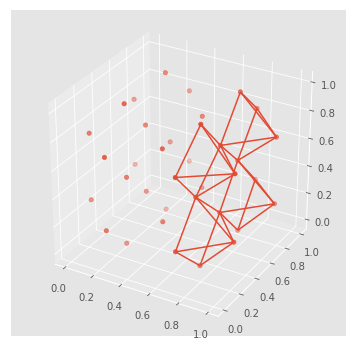

array([ 0,  0,  0, -2, -2,  0, -2,  2,  2, -2,  0, -2, -2,  0,  0,  0,  0,
       -2,  0,  2, -2,  0,  0, -2,  2,  0,  2,  0, -2,  2, -2,  2,  2,  2,
        2,  2,  2,  2, -2,  2,  2, -2,  2,  2, -2, -2, -2,  2, -2,  2,  2,
        2,  2,  2, -2,  2,  2, -2,  2,  2,  2,  2,  2, -2, -2,  2, -2, -2,
       -2, -2, -2, -2,  2,  2, -2,  2,  2, -2,  2,  2,  2, -2,  2, -2, -2,
        2, -2, -2, -2,  2,  2, -2, -2, -2, -2, -2])

In [24]:
def gen_cuboct_nodes_bars(offset):
    #Final Generation of Nodes/Bars
    tnodes = gen_base_nodes(0.0)
    tnodes, tbars = mir(tnodes,  bars,(1,0,0),tnodes[5])
    tnodes, tbars = mir(tnodes, tbars,(0,1,0),tnodes[4])
    tnodes, tbars = mir(tnodes, tbars,(0,0,1),tnodes[3])

    unique_points(tnodes)
    tnodes, tbars = unique_reduce(tnodes,tbars)

    ind = np.lexsort((tnodes[:,1],tnodes[:,0]))   
    #print(tnodes[ind])

    indind = np.argsort(ind)

    tnodes = gen_base_nodes(offset)
    tnodes, tbars = mir(tnodes,  bars,(1,0,0),tnodes[5])
    tnodes, tbars = mir(tnodes, tbars,(0,1,0),tnodes[4])
    tnodes, tbars = mir(tnodes, tbars,(0,0,1),tnodes[3])

    unique_points(tnodes)
    tnodes, tbars = unique_reduce(tnodes,tbars)

    tnodes = tnodes[ind]/2.0
    
    for i, barset in enumerate(tbars): 
        for j, node in enumerate(barset):
            barset[j] = indind[node]
        if barset[0] > barset[1]:
            tbars[i] = np.sort(barset)
        
    return tnodes,tbars

tnodes,tbars = gen_cuboct_nodes_bars(0.02)
#print(ind)
#print(indind)




barind = np.lexsort((tbars[:,1],tbars[:,0]))   

tbars = tbars[barind]



print(tnodes)
print(tbars)

fig = plt.figure(figsize=(6,6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

line_segments = []
for bar in tbars[-32:]:
    line_segments.append([tnodes[bar[0]],tnodes[bar[1]]])
line_segments = np.array(line_segments)

line_segments = Line3DCollection(line_segments)
    
max_ind = 20
ax.scatter(tnodes.T[0][:],tnodes.T[1][:],tnodes.T[2][:])
ax.add_collection(line_segments)
plt.show()

a1u_self_stress = np.array([-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,1,1,1,1,-1,1,-1,1,1,1,1,1,1,1,-1,1,1,-1,1,1,-1,-1,-1,1,-1,1,1,1,1,1,-1,1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1])
a2u_self_stress = np.array([1,1,-1,-1,-1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,1,-1,-1,1,-1,1,-1,-1,1,-1,1,1,1,1,1,1,1,-1,1,1,-1,1,1,-1,-1,-1,1,-1,1,1,1,1,1,-1,1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1])

a1u_self_stress+a2u_self_stress


In [15]:
def lattice_stiffness(nodes, frameset, unitcell_dims, beamlength, relative_density):
    E_mat = 1.0
    rho_mat = 0#1.0
    nu_mat = 0#0.3

    frame_props = {'E'   : E_mat,
                   'rho' : rho_mat,
                   'nu'  : nu_mat,
        'cross_section'  : 'circular',
                   'roll': 0,
                  'loads':{'element':0},
            'prestresses':{'element':0},
                     'Le': beamlength,
         'beam_divisions': 1,
                  'shear': False,
           'pin-jointed' : True}

    global_args = {'dof' : len(nodes)*6}
    
    beam_diameter = 2.0*np.sqrt(relative_density*unitcell_dims**3/(frameset.shape[0]*np.pi*beamlength))
    
    t_frame_props = copy.copy(frame_props)
    t_frame_props['d1'] = beam_diameter
    t_frame_props['d2'] = beam_diameter
    t_frame_props['th'] = beam_diameter/2.0
        
    out_frames = [(frameset,np.zeros((0,len(frameset))),t_frame_props)]
    K_uc = ksolver.provide_K(nodes, global_args, out_frames)

    #print(K_uc)
    tk_uc = np.zeros((global_args['dof'],global_args['dof']))
    for i,col in enumerate(K_uc.I):
        #print(K_uc.J[i])
        tk_uc[K_uc.J[i]][col] = K_uc[col*global_args['dof']+K_uc.J[i]]
    K_uc = tk_uc
    
    D_0 = -1*np.dot(np.linalg.pinv(np.dot(B_0.T,np.dot(K_uc,B_0))),np.dot(B_0.T,np.dot(K_uc,B_a)))

    D_a = np.dot(B_0,D_0)+B_a

    K_da = np.dot(D_a.T,np.dot(K_uc,D_a))

    Ke = 1.0/(unitcell_dims**3)*np.dot(Be.T,np.dot(K_da,Be))
    
    #print(D_0)
    w,v = np.linalg.eig(Ke)
    sw = np.real(np.sort(w)[::-1])
    
    #print(frame_names[frame_index])    
    #print('==============================')
    #print('Eigenvalues:\n\t '+' '.join(['{:>6.6f}'.format(item) for item in sw])+'\n')
    #print('\n')
    evals = np.zeros(3)
    print(np.real(sw))
    for i in range(len(sw)):
        evals[int(np.sum(np.abs(sw-sw[i])<1e-12))-1] = sw[i]
    #print(evals)
    #evals = np.array([sw[0],sw[1],sw[3]])
    tform = np.array([[ 1, 2, 0],
                      [ 1,-1, 0],
                      [ 0, 0, 1]])

    base = np.dot(np.linalg.inv(tform),evals)/relative_density#(frameset.shape[0]*E_mat*np.pi*(beam_diameter/2.0)**2)*beamlength**2
    #print(base*relative_density)
    #print('Kmat:\n\t'+'\n\t'.join([' '.join(['{:>6.3f}'.format(item) for item in row]) 
    #  for row in Ke/E_mat/relative_density]))
    
    #compliance = np.linalg.inv(Ke)*E_mat*relative_density
    #print('\nCompliance:\n\t'+'\n\t'.join([' '.join(['{:>6.3f}'.format(item) for item in row]) 
    #  for row in compliance]))
    '''
    print('\nCoefficients:')
    print("\t Alpha: {0:6.6f}".format(base[0])) #*frame_props["Le"]**2/frame_props["d1"]**2))#np.dot(np.linalg.inv(tform),evals))
    print("\t  Beta: {0:6.6f}".format(base[1])) #*frame_props["Le"]**2/frame_props["d1"]**2))
    print("\t Gamma: {0:6.6f}".format(base[2])) #*frame_props["Le"]**2/frame_props["d1"]**2))

    print('\nEigenvalues:')
    print("\tHydrostatic: {0:6.6f}".format(evals[0]/E_mat/relative_density))#np.dot(np.linalg.inv(tform),evals))
    print("\t Deviatoric: {0:6.6f}".format(evals[1]/E_mat/relative_density))
    print("\t      Shear: {0:6.6f}".format(evals[2]/E_mat/relative_density))

    print("\n")
    '''
    return beam_diameter, evals/E_mat/relative_density
    
unitcell_dims = 1.0
beamlength = 0.5*unitcell_dims/np.sqrt(2)

tnodes,tbars = gen_cuboct_nodes_bars(0.001)

lattice_stiffness(tnodes,tbars, unitcell_dims, beamlength,0.01)

[  8.33326667e-04   8.33326667e-04   8.33326667e-04   1.67668655e-14
   1.32563813e-14   3.66593278e-15]


(0.019368319452105136,
 array([  0.00000000e+00,   0.00000000e+00,   3.66593278e-13]))

In [12]:
rd_0_1_evals = [ 8.33326667e-03 , 0.00833333,  0.00833333]

beamlength = 0.5*unitcell_dims/np.sqrt(2)
beam_diameter = 0.061248003918396743

print(rd_0_1_evals[0]/(np.pi*np.power(0.5*beam_diameter,2))*np.power(beamlength,2))


0.353550562308


In [13]:
unitcell_dims = 1.0

offsets_base = np.power(10,-np.arange(1.2,3.5,0.1))
reldens = [0.1,0.01,0.001,0.0001]
offsets = []
outputs = []

for i,rel_den in enumerate(reldens):
    outputs.append([])
    offsets.append([])
    for offset in offsets_base:
        beamlength = np.sqrt(np.sum(np.power(np.array([0.5+offset,0.5-offset,2*offset])/2,2)))
    
        tnodes,tbars = np.array(gen_cuboct_nodes_bars(offset))
        bd, vals = lattice_stiffness(tnodes,tbars,unitcell_dims,beamlength,rel_den)
        outputs[i].append(vals)
        #print(beamlength)
        offsets[i].append(beamlength/(0.25*np.sqrt(2)))
        
    #print('------')

In [14]:
print((0.25*np.sqrt(2)))

0.353553390593


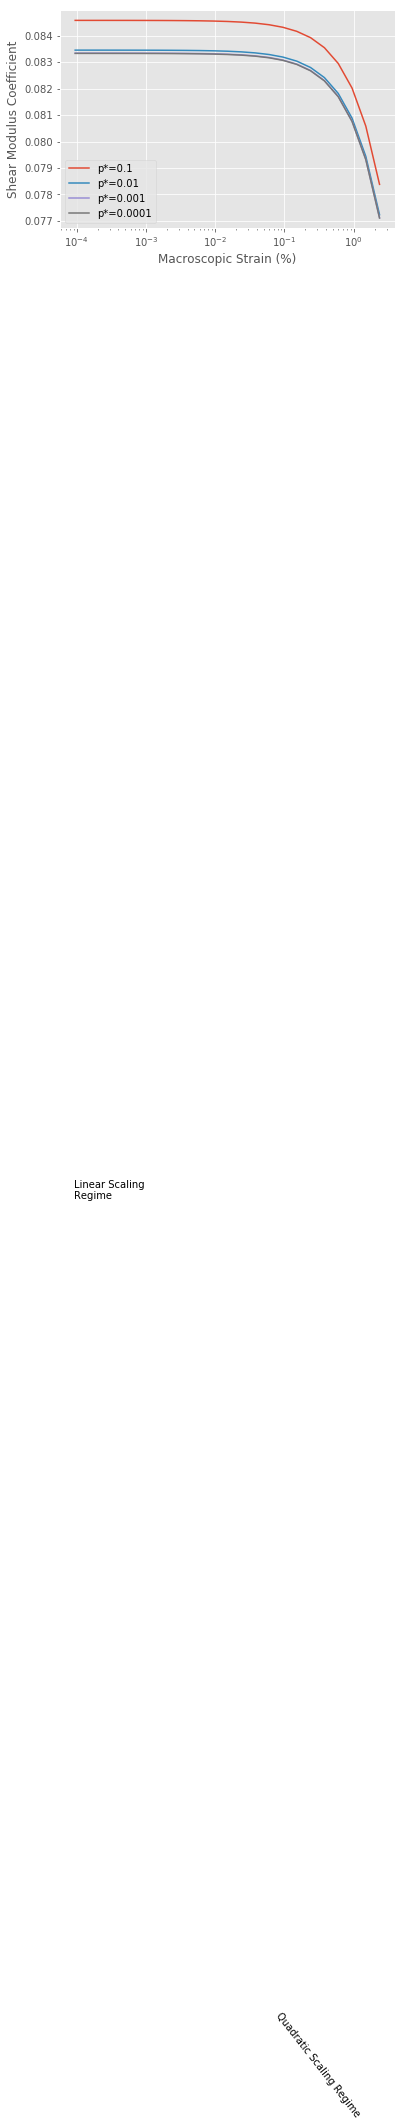

In [20]:
outputs = np.array(outputs)
for i in range(len(offsets)):
    plt.plot((np.array(offsets[i])-1)*100,outputs[i].T[2],label="p*={0}".format(reldens[i]))

plt.legend(loc=3)
#plt.title('Stability of the Infinitesimal Mechanism Mode in Cuboct')
plt.ylabel('Shear Modulus Coefficient')
plt.xlabel('Macroscopic Strain (%)')
plt.xscale('log')
#plt.yscale('log')
plt.text(0.00009,0.04,"Linear Scaling\nRegime")
plt.text(0.07,0.009,"Quadratic Scaling Regime",rotation=-52)
plt.savefig("CO_SM_scaling.pdf")
plt.show()


In [16]:
print(outputs[0].T[0])

[ 0.10375353  0.14155206  0.18129912  0.2189127   0.2511483   0.27651954
  0.29518525  0.3082477   0.31707242  0.32289322  0.32667226  0.32910056
  0.33065058  0.3316358   0.33226033  0.33265554  0.33290537  0.33306318
  0.33316283  0.33322573  0.33326544  0.33329049  0.3333063 ]
